In [2]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd
import librosa
import librosa.display
import os
from os import path
import io
!pip3 install soundfile
!pip3 install librosa
import soundfile as sf
import librosa.feature


In [3]:
!pip install ipython-autotime

%load_ext autotime

# Opening datasets

In [0]:
DIR = '/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class' 
DIR_AUDIO = DIR + '/soundfiles/TAU-urban-acoustic-scenes-2020-3class-development/'
df_meta = pd.read_csv(f'{DIR}/meta.csv')
df_meta = pd.read_csv(io.StringIO(df_meta.to_csv(index=False)))
df_meta.head()

,filename,scene_label,identifier
0,audio/airport-barcelona-0-0-a.wav,indoor,barcelona-0
1,audio/airport-barcelona-0-10-a.wav,indoor,barcelona-0
2,audio/airport-barcelona-0-11-a.wav,indoor,barcelona-0
3,audio/airport-barcelona-0-12-a.wav,indoor,barcelona-0
4,audio/airport-barcelona-0-13-a.wav,indoor,barcelona-0


time: 109 ms


# Getting part of the dataset
Não coloquei 10% dele, pois poderiam vir mais datasets de um label específico. E nem coloquei 10% de cada label, pois a quantidades de datasets dentro de cada label é diferente. Então defini n datasets de cada label.

In [0]:
df = df_meta.groupby('scene_label', as_index=False).apply(lambda x: x.sample(frac=1, random_state=15))
df.index = [i[1] for i in df.index]
df.head()

,filename,scene_label,identifier
3028,audio/metro_station-helsinki-231-6952-a.wav,indoor,helsinki-231
9493,audio/shopping_mall-milan-1183-45376-a.wav,indoor,milan-1183
4163,audio/metro_station-stockholm-85-2308-a.wav,indoor,stockholm-85
3224,audio/metro_station-lisbon-1020-42471-a.wav,indoor,lisbon-1020
9294,audio/shopping_mall-lyon-1066-42583-a.wav,indoor,lyon-1066


time: 39.6 ms


In [0]:
# so neste caso q n vamos usar transportation
#df = df.loc[df['scene_label'] != 'transportation']

time: 845 µs


In [0]:
print(df.loc[df['scene_label'] == 'outdoor'].shape)
print(df.loc[df['scene_label'] == 'indoor'].shape)
print(df.loc[df['scene_label'] == 'transportation'].shape)

(5760, 3)
(4320, 3)
(4320, 3)
time: 10.4 ms


Reading the datasets and storing it to 'signals'

In [0]:
info_sound = df[['filename','scene_label']].to_numpy()

time: 3.87 ms


In [4]:
LABELS = ['indoor', 'outdoor', 'transportation']

time: 929 µs


In [5]:
FILEPATH = '/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/features.csv'

time: 931 µs


Labels:


0.   Indoor
1.   Outdoor
2.   Transportation



In [0]:
def clear_csv(FILEPATH):
    if os.path.exists(FILEPATH):
        # clear the file
        f = open(FILEPATH, "w")
        f.truncate()
        f.close()

time: 2.24 ms


# Getting Features

1.   Centroid Mean
2.   Centroid STD
3.   Flatness Mean
4.   Flatness STD
5.   RMS



In [0]:
PARTS = 20
def get_features(signal, label, music_id)->pd.DataFrame:
    # LUANA - FEATURES
    def get_centroid(y, sr):
        return librosa.feature.spectral_centroid(y=y, sr=sr)
    def get_flatness(y):
        return librosa.feature.spectral_flatness(y=y)
    def get_rms(y):
        return librosa.feature.rms(y=y)
    def get_mfccs(y, sr):
        return librosa.feature.mfcc(y=y, sr=sr)

    feats = (np.zeros((1,47))[0])
    
    music_features = []
    signal = signal[:,0]
    for second in np.array_split(signal, PARTS):
        arr_mfcc = []
        #print(second.shape)
        c = get_centroid(second, SAMPLERATE)
        f = get_flatness(second)
        r = get_rms(second)
        mfccs = get_mfccs(second, SAMPLERATE)
        #print(np.array(mfccs).shape)
        mfccs = [[np.mean(x), np.std(x)] for x in mfccs]
        mfccs = np.array(mfccs).reshape(1,-1)[0]
        #print(mfccs.shape)
        mfccs = np.array_split(mfccs, mfccs.shape[0])
        #print(np.array(mfccs).shape)
        [arr_mfcc.append(x[0]) for x in mfccs]
        music_features = np.hstack([arr_mfcc, np.array([np.mean(c),np.std(c),np.mean(f), np.std(f),r[0][0], label, music_id])]) 
        #print(np.array(music_features).shape)
        feats = np.vstack([feats, music_features])  
            
    return pd.DataFrame(data=feats).drop(0).reset_index(drop=True)

time: 21.1 ms


In [0]:
'''SAMPLERATE = 48000
clear_csv(FILEPATH)
music_id = 0
for filename, label in info_sound:
    music_id += 1
    if(path.isfile(os.path.join(DIR_AUDIO, filename))):
        signal, sr = sf.read(os.path.join(DIR_AUDIO, filename))
        feats = get_features(signal, LABELS.index(label), music_id)
        if (music_id == 1): 
            feats.to_csv(FILEPATH, mode='a', header=True, index=False)
        else:
            feats.to_csv(FILEPATH, mode='a', header=False, index=False)
'''

"SAMPLERATE = 48000\nclear_csv(FILEPATH)\nmusic_id = 0\nfor filename, label in info_sound:\n    music_id += 1\n    if(path.isfile(os.path.join(DIR_AUDIO, filename))):\n        signal, sr = sf.read(os.path.join(DIR_AUDIO, filename))\n        feats = get_features(signal, LABELS.index(label), music_id)\n        if (music_id == 1): \n            feats.to_csv(FILEPATH, mode='a', header=True, index=False)\n        else:\n            feats.to_csv(FILEPATH, mode='a', header=False, index=False)\n"

time: 3.96 ms


In [6]:
df = pd.read_csv(FILEPATH)

time: 2.93 s


In [7]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46
0,-563.449644,22.023184,135.878246,18.579833,22.520302,7.300311,16.225448,9.895189,24.840216,7.931395,17.735182,4.958907,-1.629153,4.904015,15.181699,6.808718,10.174596,6.249919,-3.917101,5.578933,10.456240,4.728516,4.644763,4.221269,-1.912056,4.788454,8.108179,3.608163,3.007513,5.006837,3.497817,3.842293,2.312008,3.892473,11.537672,4.325387,-0.749163,4.038345,7.118216,3.643633,2829.089223,702.443965,0.001764,0.001120,0.002695,0.0,1.0
1,-562.503335,20.702541,140.065796,8.147038,16.625603,7.073399,9.495887,6.955631,18.206718,10.410231,11.241618,4.197412,-3.428479,3.589219,21.499875,4.131287,11.862166,4.058275,0.937668,6.122206,13.807700,3.715036,7.323432,4.460393,1.548952,3.240698,8.906422,4.210608,1.818789,4.106325,5.265932,4.201313,4.596878,4.204631,10.503731,3.329537,-2.345872,4.212205,5.490622,3.335060,2754.634654,463.176690,0.001833,0.001352,0.001839,0.0,1.0
2,-549.838575,24.127966,148.962852,20.111527,8.936889,9.354859,10.757130,7.886489,14.726544,7.286063,14.760088,5.566642,-5.590292,2.983038,15.539512,6.084150,6.786404,5.972727,0.826314,5.146685,10.804998,4.779526,8.386244,5.108089,-0.220129,5.098121,8.760563,5.321104,1.947787,4.053670,7.038692,4.276606,6.076221,4.329260,10.546924,3.983716,0.036168,4.076422,4.225855,3.735124,2594.760352,764.967181,0.002698,0.003042,0.002236,0.0,1.0
3,-565.434882,14.754470,148.064518,9.718337,13.556576,9.799333,18.032755,5.658596,22.516785,5.587385,14.656247,4.589856,-6.977173,4.388427,14.558317,4.930122,2.734255,5.010734,-4.641390,4.563014,7.076269,3.819575,6.664245,3.580998,0.022985,4.845357,8.652071,5.106633,2.963710,4.311297,3.818885,4.703418,3.692539,4.448284,7.547152,4.171675,-0.509109,4.109532,5.475766,3.807331,2509.610762,450.748426,0.001929,0.001001,0.003392,0.0,1.0
4,-559.139540,18.129553,144.104684,13.184655,9.718551,11.348594,16.154283,9.285637,20.654607,8.414770,13.846495,4.992407,-7.451154,5.844608,17.774799,4.793385,7.210570,6.552409,0.534129,5.149643,10.262997,4.844157,7.969145,4.246584,2.045861,3.579869,9.713472,4.215063,0.434847,3.763315,5.087198,3.230810,4.845782,3.362537,9.218363,3.573434,-2.622925,4.726460,2.658035,3.554823,2564.704840,488.190754,0.001820,0.001080,0.002089,0.0,1.0


time: 92.3 ms


In [9]:
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
import pickle
from collections import Counter
from sklearn.decomposition import PCA
import seaborn as sns

time: 39.3 ms


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Split no dataframe baseado em grupos do número da música

In [10]:
def split_by_music_id(df):
    train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 2).split(df, groups=df['46']))
    return [train_inds, test_inds]

time: 1.72 ms


Split no dataframe selecionado, em teste e treino

In [11]:
def split_train_test(df,train_inds, test_inds):
    X_train = (df.iloc[train_inds, 0:-2])
    X_test = (df.iloc[test_inds,0:-2])
    y_train = (df.iloc[train_inds,[-2,-1]]).values
    y_test = (df.iloc[test_inds,[-2,-1]]).values
    #print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    return [X_train, X_test, y_train, y_test]

time: 3.38 ms


In [12]:
def standardize(X_train, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train.values)
    X_train = scaler.transform(X_train.values)
    X_test = scaler.transform(X_test.values)
    return [X_train, X_test]

time: 2.05 ms


# Random Forest Classifier

In [14]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

time: 95.7 ms


In [24]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV

time: 1.21 ms


In [48]:
def best_estimator(forest, X_train, y_train):
    n_estimators = [100, 300, 500, 800, 1000, 1200]

    hyperF = dict(n_estimators = n_estimators)

    gridF = GridSearchCV(forest, hyperF, cv = 3, verbose = 1, 
                        n_jobs = -1)
    return gridF.fit(x_train, y_train)
def plot_feature_importances(feature_imp):
    plt.figure(figsize=(15,10))
    y = [round(num, 3) for num in feature_imp]
    sns.barplot(x=np.arange(0,45), y=y)
    # Add labels to your graph
    plt.xlabel('Feature Importance Score')
    plt.ylabel('Features')
    plt.xticks(np.arange(0,45))
    plt.title("Visualizing Important Features")
    plt.legend()
    plt.show()

def get_model_random_forest(X_train,y_train, y_test, X_test):
    #Create a Gaussian Classifier
    clf=RandomForestClassifier(random_state=42, n_estimators=100)

    #Train the model using the training sets y_pred=clf.predict(X_test)
    clf.fit(X_train,y_train)
    # prediction on test set
    y_pred = clf.predict(X_test)
    print("Accuracy Sem Votação:",metrics.accuracy_score(y_test, y_pred))
    #print([{id_feat:feature_importance} for id_feat, feature_importance in enumerate(clf.feature_importances_)])
    plot_feature_importances(clf.feature_importances_)
    return clf, y_pred

time: 16.3 ms


Contagem das predições para cada música

In [18]:
def contagem_predicoes(y_test, y_pred):
    counts = dict()
    for id in np.unique(y_test[:,1]):
        counts[id] = []
    #print(counts)
    for t, p in zip(y_test, y_pred):
        counts[t[1]].append(p)
    counter = [Counter(y) for x,y in counts.items()]
    return counter

def acc_votacao(counter, y_test):
    #print(np.unique(y_test[1]))
    #print(counter, y_test)
    music_y_pred = [max(x, key=x.get) for x in counter]
    #print(music_y_pred)
    #music_y_test = [[x,y] for x,y in y_test]
    #music_y_test = np.unique(music_y_test, axis=0)[:,0]
    music_y_test = np.unique(y_test, axis=0)[:,0]
    #print(music_y_test)
    return metrics.accuracy_score(music_y_test,music_y_pred)

time: 10.9 ms


In [19]:
def pca(X_test, y_test):
    pca = PCA(3)
    trans_pca = pca.fit_transform(X_test)
    trans_pca = pd.DataFrame(trans_pca)
    trans_pca['Labels'] = y_test[:,0]
    trans_pca["Labels"] = ["$%s$" % x for x in trans_pca["Labels"]]
    print(pca.explained_variance_)
    trans_pca.columns = ['PC1', 'PC2','PC3','Labels']
    plt.figure(figsize=(10,6))
    sns.scatterplot(x=trans_pca['PC1'], y=trans_pca['PC2'], hue=trans_pca['Labels'])

time: 4.72 ms


In [36]:
def classify(df):
    train_inds, test_inds = split_by_music_id(df)
    X_train, X_test, y_train, y_test = split_train_test(df,train_inds, test_inds)
    X_train, X_test = standardize(X_train, X_test)
    rf_model, y_pred = get_model_random_forest(X_train,y_train[:,0], y_test[:,0], X_test)
    contagens = contagem_predicoes(y_test, y_pred)
    final_accuracy = acc_votacao(contagens, y_test)
    pca(X_test, y_test)
    return final_accuracy

time: 3.6 ms


Accuracy Sem Votação: 0.8751217532467532


No handles with labels found to put in legend.


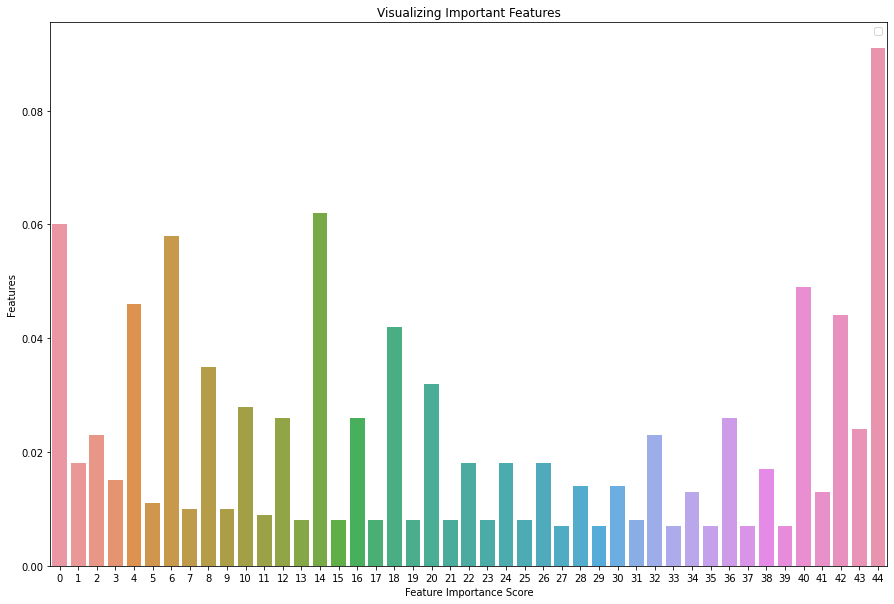

[8.61838576 4.69293837 2.9054269 ]
0.9155844155844156


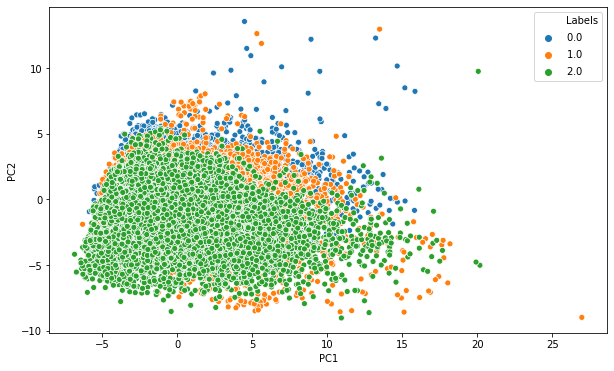

time: 3min 12s


In [49]:
acc = classify(df)
print(acc)

Features: Descrição

*   0-39: MFCSS (media, std) nessa ordem
*   40: média centroide 
*   41: std centroide
*   42: media flatness
*   43: std flatness
*   44: rms


